In [320]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as pl
from scipy.spatial.distance import cdist
from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel

Following Suzanne Aigrain's LSST tutorial on GPs: https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/GPLecture1.ipynb

In [2]:
def SEKernel(par, x1, x2):
    A, Gamma = par
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    return A * np.exp(-Gamma*D2)

def PeriodicKernel(par, x1, x2):
    A, Gamma, length, P, sigma = par
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    arg = -D2
    return A * np.exp(arg)

def PeriodicKernel(par, x1, x2):
    # hold up, the george library has an ExpSquaredKernel in addition to an ExpSine2Kernel and WhiteKernel for noise
    return "placeholder"

def Pred_GP(CovFunc, CovPar, xobs, yobs, eobs, xtest):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, xobs, xobs) 
    # add white noise
    K += np.identity(xobs.shape[0]) * eobs**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, xtest, xtest)
    # evaluate the cross-term
    Ks = CovFunc(CovPar, xtest, xobs)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, yobs))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov

In [3]:
import pandas as pd

ts = pd.read_csv('/Users/chris/Desktop/superflares/c12/246300000/01900/ts.txt', sep=", ", header=0)
ts.columns = ["BJD - 2454833", "Corrected Flux"] 
print(ts.head())
print(ts.tail())

   BJD - 2454833  Corrected Flux
0    2905.581553        0.984912
1    2905.601985        0.985306
2    2905.622418        0.985967
3    2905.642850        0.985878
4    2905.663282        0.986161
      BJD - 2454833  Corrected Flux
3348    2984.161921        1.039136
3349    2984.182353        1.038834
3350    2984.202784        1.044875
3351    2984.223216        1.042245
3352    2984.243648        1.041783


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


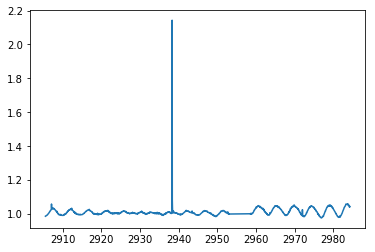

In [137]:
pl.plot(ts["BJD - 2454833"], ts["Corrected Flux"])
pl.show()

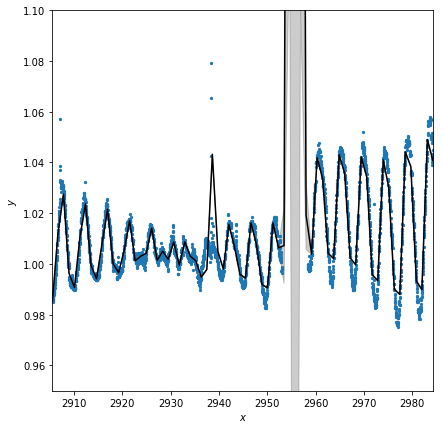

In [4]:
xobs = np.array(ts["BJD - 2454833"])
yobs = np.array(ts["Corrected Flux"])
eobs = 0.001*np.ones(len(ts)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5

pl.subplot(121)
#pl.errorbar(xobs,yobs,eobs,capsize=0,fmt='k.')
x = np.linspace(2905.56,2984.26,70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
pl.plot(x,m,'k-')
pl.fill_between(x,m+sig,m-sig,color='k',alpha=0.2)
pl.xlim(2905.56,2984.26)
pl.ylim(0.95,1.1)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$')
pl.scatter(ts['BJD - 2454833'], ts['Corrected Flux'],s=5);

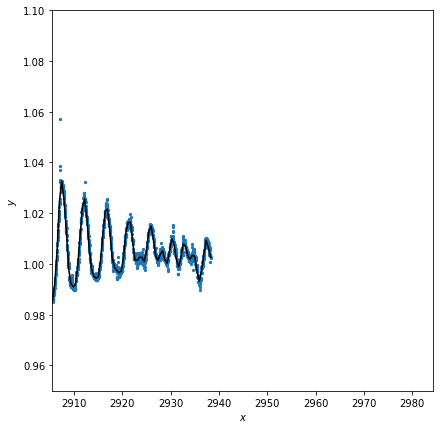

In [340]:
pre = ts.loc[:1513]
xobs = np.array(pre["BJD - 2454833"])
yobs = np.array(pre["Corrected Flux"])
eobs = 0.001*np.ones(len(pre)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5

pl.subplot(121)
x = np.linspace(2905.56,2984.26,70)
x = np.linspace(pre['BJD - 2454833'][0], pre['BJD - 2454833'][len(pre)-1], 70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))

pl.plot(x,m,'k-')
pl.fill_between(x,m+sig,m-sig,color='k',alpha=0.2)
pl.xlim(2905.56,2984.26)
pl.ylim(0.95,1.1)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$')
pl.scatter(pre['BJD - 2454833'], pre['Corrected Flux'],s=5);

Meanwhile, here's what happens when I subtract out the inference from the data.

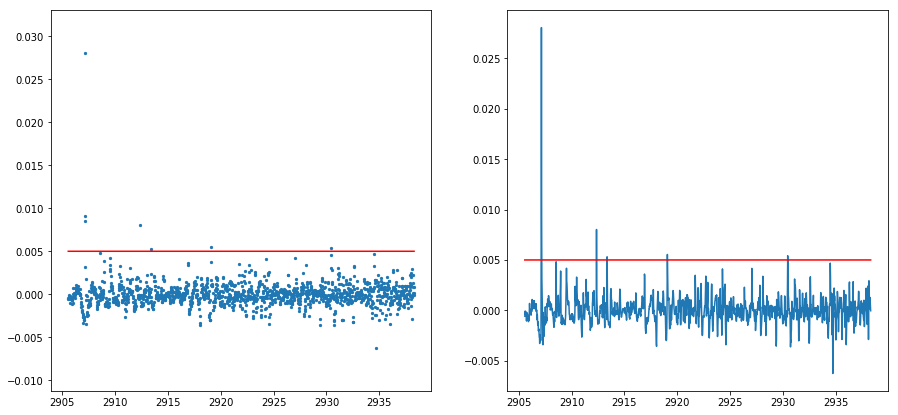

In [341]:
xobs = np.array(pre["BJD - 2454833"])
yobs = np.array(pre["Corrected Flux"])
eobs = 0.001*np.ones(len(pre)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5
threshold = 0.005

pl.subplot(121)
#x = np.linspace(2905.56,2984.26,70)
x = np.linspace(pre['BJD - 2454833'][0], pre['BJD - 2454833'][len(pre)-1], 70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
##pl.plot(pre['BJD - 2454833'],pre['Corrected Flux']-1)

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs = CubicSpline(x, m)
###pl.plot(pre['BJD - 2454833'], cs(pre['BJD - 2454833'])-1)

pl.subplot(121)
pl.scatter(pre['BJD - 2454833'],pre['Corrected Flux']-cs(pre['BJD - 2454833']),s=5)
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
pl.subplot(122)
pl.plot(pre['BJD - 2454833'],pre['Corrected Flux']-cs(pre['BJD - 2454833']))
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')

And the second half of the time series...

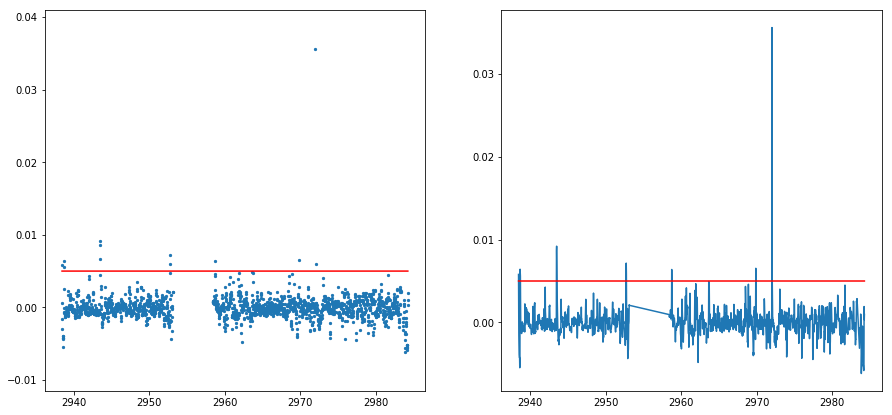

In [325]:
post = ts.iloc[1519:].reset_index()
xobs = np.array(post["BJD - 2454833"])
yobs = np.array(post["Corrected Flux"])
eobs = 0.001*np.ones(len(post)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5

# inference on post-super flare time series
pl.subplot(121)
x = np.linspace(post['BJD - 2454833'][0], post['BJD - 2454833'][len(post)-1], 70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x) 
sig = np.sqrt(np.diag(C))
###pl.plot(post['BJD - 2454833'],post['Corrected Flux']-1)

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs = CubicSpline(x, m)
###pl.plot(post['BJD - 2454833'], cs(post['BJD - 2454833'])-1)

pl.subplot(121)
pl.scatter(post['BJD - 2454833'],post['Corrected Flux']-cs(post['BJD - 2454833']),s=5)
threshold = 0.005
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
pl.subplot(122)
pl.plot(post['BJD - 2454833'],post['Corrected Flux']-cs(post['BJD - 2454833']))
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')


Full timeseries - caution: fitting the whole thing causes the intensity around the super flare to be over-predicted. See further below.

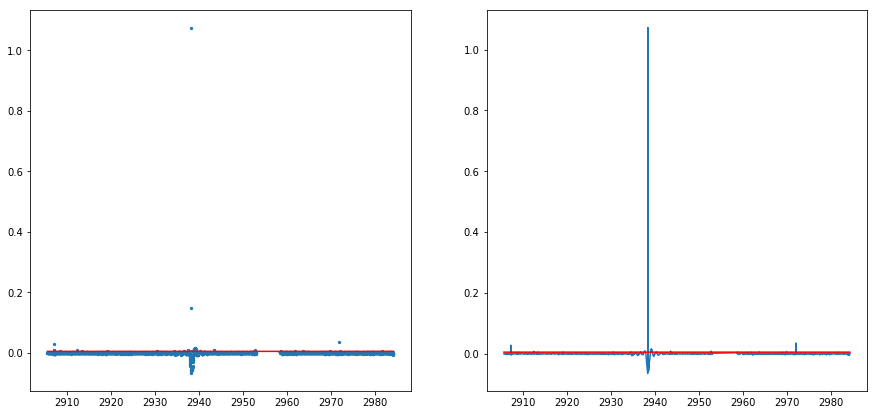

In [254]:
xobs = np.array(ts["BJD - 2454833"])
yobs = np.array(ts["Corrected Flux"])
eobs = 0.001*np.ones(len(ts)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5
threshold = 0.005

pl.subplot(121)
x = np.linspace(ts['BJD - 2454833'][0], ts['BJD - 2454833'][len(ts)-1], 140)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs = CubicSpline(x, m)

pl.subplot(121)
pl.scatter(ts['BJD - 2454833'],ts['Corrected Flux']-cs(ts['BJD - 2454833']),s=5)
threshold = 0.005
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
#pl.ylim([-0.005,0.04])

pl.subplot(122)
pl.plot(ts['BJD - 2454833'],ts['Corrected Flux']-cs(ts['BJD - 2454833']))
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
#pl.ylim([-0.005,0.04])

pl.show()

**FLARES**

Using an actual peak finder to find flares' times, widths, and heights

**Pre chunk**

1514 5
[  71  311  358  627 1154]


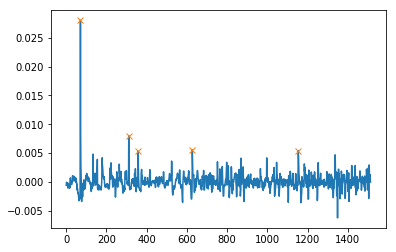

In [342]:
# pre chunk
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

y = pre['Corrected Flux']-cs(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

In [343]:
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=8)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)


Peaks: 
71      0.028066
311     0.008024
358     0.005311
627     0.005545
1154    0.005419
Name: Corrected Flux, dtype: float64
Prominences:  [0.02817136 0.00862463 0.00609664 0.00454701 0.00420422]
Left bases:  [  68  308  357  623 1151]
Right bases:  [  75  315  362  631 1158]
Widths:  [7 7 5 8 7]


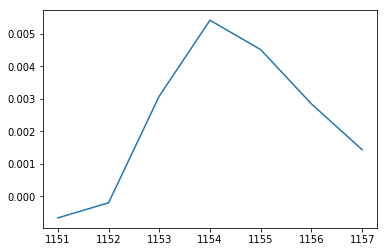

In [344]:
# flare width, for example comparison
pl.plot(y[1151:1158])
pl.show()

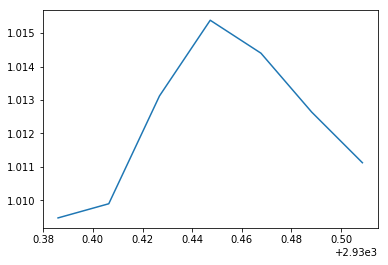

In [345]:
start = 1151
end = 1158
pl.plot(ts["BJD - 2454833"][start:end], ts["Corrected Flux"][start:end])
pl.show()

**Post chunk**

1834 6
[  10  226  652  686 1192 1291]


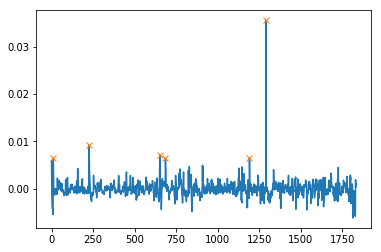

In [326]:
# post chunk
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

y = post['Corrected Flux']-cs(post['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=1) 
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()


In [327]:
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=4)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
10      0.006421
226     0.009206
652     0.007159
686     0.006391
1192    0.006534
1291    0.035611
Name: Corrected Flux, dtype: float64
Prominences:  [0.00390015 0.00475814 0.00503752 0.00211764 0.00555457 0.03496371]
Left bases:  [   8  224  650  684 1191 1289]
Right bases:  [  12  228  654  688 1194 1293]
Widths:  [4 4 4 4 3 4]


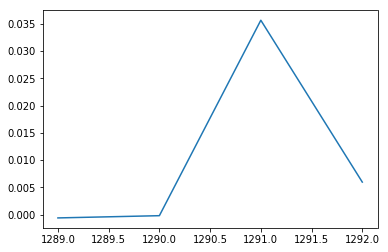

In [328]:
# flare width, for example comparison
pl.plot(y[1289:1293])
pl.show()

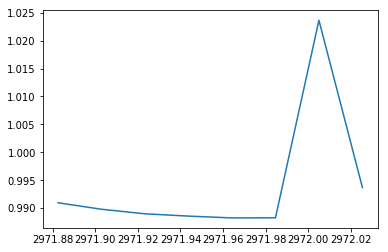

In [329]:
start = 1285 + 1519
end = 1293 + 1519
pl.plot(ts["BJD - 2454833"][start:end], ts["Corrected Flux"][start:end])
pl.show()

Evidently 30-minute cadence might not be granular enough to be the right tool for capturing flare duration.

**Full timeseries**

For completeness's sake. See caution above on over-predicting near the superflare, which is probably why flares here are a bit different than in corresponding chunks.

3353 12
[  71  311  627 1154 1337 1437 1515 1604 1745 2171 2711 2810]


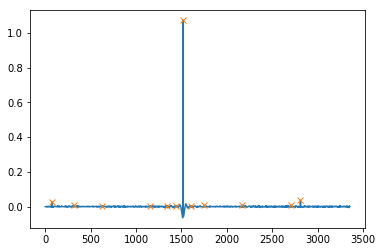

In [255]:
y = ts['Corrected Flux']-cs(ts['BJD - 2454833'])
peaks, _ = find_peaks(y, height=0.005, distance=48) # ignore smaller peaks within 24 hours of peak
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

In [256]:
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=4)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
71      0.027864
311     0.007975
627     0.005608
1154    0.005538
1337    0.006039
1437    0.006150
1515    1.072436
1604    0.005329
1745    0.008610
2171    0.008268
2711    0.006813
2810    0.035054
Name: Corrected Flux, dtype: float64
Prominences:  [0.02500672 0.00734641 0.00378779 0.00259818 0.00401452 0.00193486
 1.06477373 0.00194902 0.00459454 0.00532601 0.00560907 0.03470885]
Left bases:  [  69  309  625 1152 1335 1435 1513 1602 1743 2169 2710 2808]
Right bases:  [  73  313  629 1156 1339 1438 1517 1606 1747 2173 2713 2812]
Widths:  [4 4 4 4 4 3 4 4 4 4 3 4]


**PERIOD AND AMPLITUDE CHANGE**

First retrieve peaks of the curve fitted to the data

**Pre**

1514 11
[  85  299  517  742  849  942 1054 1149 1261 1349 1473]


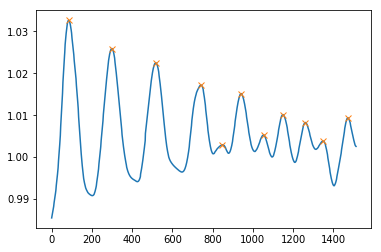

[214 218 225 107  93 112  95 112  88 124]


In [346]:
# run peak finder on the GP-produced curve only...with more liberal threshold
y = cs(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, distance=1) # or 50 hours
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

print(np.diff(peaks))

1514 8
[  85  299  517  742  942 1149 1261 1473]


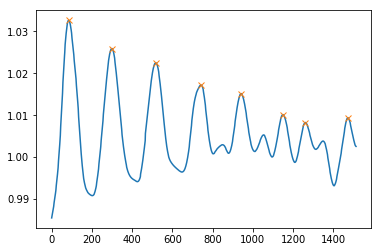

[214 218 225 200 207 112 212]


In [352]:
# run peak finder on the GP-produced curve only...with more conservative threshold
y = cs(pre['BJD - 2454833'])
peaks, _ = find_peaks(y, distance=100) # or 50 hours
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

print(np.diff(peaks))

From both of these and the raw data below, it's tough to tell what's really going on in terms of peak spacing during the days leading up to the super flare.

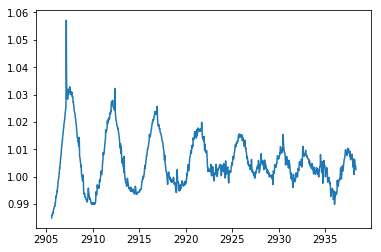

In [312]:
pl.plot(pre['BJD - 2454833'], pre['Corrected Flux'])
pl.show()

In [288]:
# peak stats for more conservative peak threshold
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=250)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
[1.03268615 1.02593674 1.02251769 1.01721967 1.01516693 1.01016331
 1.00827354 1.00941936]
Prominences:  [0.04187435 0.03177323 0.02601101 0.01642034 0.01381362 0.01011971
 0.00951856 0.00685024]
Left bases:  [   0  202  426  647  880 1096 1209 1404]
Right bases:  [ 202  424  642  803 1010 1209 1386 1513]
Widths:  [202 222 216 156 130 113 177 109]


Peak widths seem pretty uniform until closer to the super flare when they get skinnier.

Amplitude also seems to decay linearly (possibly logarithmically?). Next to do will be to fit some models.

In [386]:
### MODELS...pre fitting, just for plotting

# proxy for linear model to calibrate curve_fit params
def linear_test(x):
    return -0.0003*x + 1.035

# proxy for sqrt model to calibrate initial conditions and test curve_fit's params
def sqrt_test(x):
    return 1.*np.sqrt(1-0.9*x**2)+1.035

# proxy for log model to calibrate initial conditions and test curve_fit's params
def log_test(x):
    return -0.004*np.log(1.*x) + 1.035

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


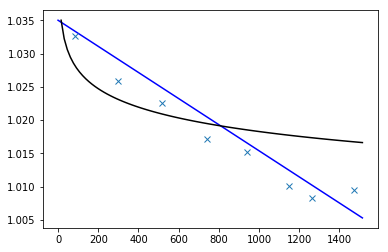

In [387]:
### PLOTTING
y_sqrt_test = []
y_linear_test = []
y_log_test = []

x = np.linspace(0,len(pre),100)
for i in range(100):
    y_sqrt_test.append(sqrt_test(i))
    y_linear_test.append(linear_test(i))
    y_log_test.append(log_test(i))
    
pl.plot(x,y_linear_test,color='b')
#pl.plot(x,y_sqrt_test,color='g')
pl.plot(x,y_log_test,color='k')
pl.plot(peaks, y[peaks], "x")
pl.show()


Some real fits are needed.

**Post**

1834 9
[ 165  379  597  768  979 1188 1395 1609 1804]


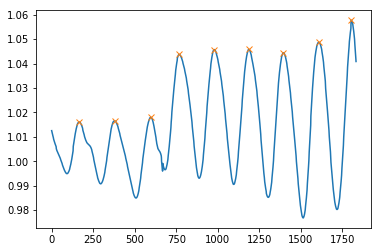

[214 218 171 211 209 207 214 195]


In [331]:
# run peak finder on the GP-produced curve only...with more liberal threshold
y = cs(post['BJD - 2454833'])
peaks, _ = find_peaks(y, distance=100) # or 50 hours
pl.plot(y)
print(len(y), len(peaks))
print(peaks)
pl.plot(peaks, y[peaks], "x")
pl.show()

print(np.diff(peaks))

Interesting that the second biggest flare after the super flare in this time series happens to be during the only significantly deviant gap (85.5 hours rather than 100+ hours)

In [332]:
# peak stats
print("Peaks: ")
print(y[peaks])
prominences, left_bases, right_bases = peak_prominences(y, peaks, wlen=250)
print("Prominences: ", prominences)
print("Left bases: ", left_bases)
print("Right bases: ", right_bases)
print("Widths: ", right_bases-left_bases)

Peaks: 
[1.01606613 1.01653192 1.01797359 1.04373986 1.04569511 1.04578587
 1.04437873 1.04870841 1.05771267]
Prominences:  [0.02115859 0.02578867 0.02201905 0.04778532 0.05267169 0.05528119
 0.05917075 0.06847126 0.01689348]
Left bases:  [  92  296  508  668  889 1096 1304 1515 1718]
Right bases:  [ 290  504  668  889 1096 1304 1515 1718 1833]
Widths:  [198 208 160 221 207 208 211 203 115]


And same with widths. Is the flare somehow responsible for the early 'exit' from its current period?

Amplitudes here don't seem to follow anything other than a flat step function (before secondary flare and after secondary flare), but the last couple periods suggest a ramping up of amplitude...although with only three points, it's tough to say anything else about it.